In [1]:
import pandas as pd
from DeepRetail.data.dataloader import Reader
from DeepRetail.transformations.formats import transaction_df
from DeepRetail.forecasting.statistical import StatisticalForecaster

/home/filtheo/DeepRetail/.venv/lib/python3.8/site-packages/statsforecast/core.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
df = pd.read_csv('/home/filtheo/DeepRetail/DeepRetail/data/data_folder/m5_day.csv', index_col=0)
df.head()

,2011-01-29,2011-01-30,2011-01-31,2011-02-01,2011-02-02,2011-02-03,2011-02-04,2011-02-05,2011-02-06,2011-02-07,...,2016-04-15,2016-04-16,2016-04-17,2016-04-18,2016-04-19,2016-04-20,2016-04-21,2016-04-22,2016-04-23,2016-04-24
unique_id,,,,,,,,,,,,,,,,,,,,,
HOBBIES_1_001_CA_1,0,0,0,0,0,0,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
HOBBIES_1_002_CA_1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
HOBBIES_1_003_CA_1,0,0,0,0,0,0,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
HOBBIES_1_004_CA_1,0,0,0,0,0,0,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
HOBBIES_1_005_CA_1,0,0,0,0,0,0,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


In [3]:
# get a sample 
sampled_df = df.sample(20)
sampled_df.head()

,2011-01-29,2011-01-30,2011-01-31,2011-02-01,2011-02-02,2011-02-03,2011-02-04,2011-02-05,2011-02-06,2011-02-07,...,2016-04-15,2016-04-16,2016-04-17,2016-04-18,2016-04-19,2016-04-20,2016-04-21,2016-04-22,2016-04-23,2016-04-24
unique_id,,,,,,,,,,,,,,,,,,,,,
HOUSEHOLD_2_090_TX_3,0,1,0,0,0,0,1,0,2,1,...,0,3,0,0,0,0,1,0,1,1
HOUSEHOLD_2_005_CA_3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
FOODS_1_028_CA_1,0,0,0,0,0,0,0,0,0,0,...,1,5,4,2,1,1,1,3,0,0
HOUSEHOLD_1_082_CA_2,0,0,0,0,0,0,0,0,0,0,...,2,3,1,1,0,2,0,0,1,1
FOODS_3_148_TX_2,9,11,6,3,1,8,5,0,0,5,...,0,0,0,0,0,3,4,1,1,0


In [4]:
# convert to transaction
t_df = transaction_df(sampled_df)

In [5]:
freq = 'M'
h = 4
holdout = True
cv = 2
models = ['ETS']

In [6]:
# Convert columns to datetime
sampled_df.columns = pd.to_datetime(sampled_df.columns)

# Resample columns to montly frequency
sampled_df = sampled_df.resample('M', axis=1).sum()

In [7]:
# Define the forecaster
forecaster = StatisticalForecaster(models = models, freq = freq)

# Fit the forecaster
forecaster.fit(sampled_df, format = 'pivoted')

# predict
forecast_df = forecaster.predict(h = h, cv = cv, holdout = holdout)

In [29]:
forecast_df.head()

,date,cutoff,unique_id,y,Model,True,fh,cv
0,2016-01-31,2015-11-30,FOODS_1_063_CA_3,-0.372100,ETS,0,1,1
1,2016-01-31,2015-12-31,FOODS_1_063_CA_3,-0.372100,ETS,0,1,2
2,2016-02-29,2015-11-30,FOODS_1_063_CA_3,7.826057,ETS,0,2,1
3,2016-02-29,2015-12-31,FOODS_1_063_CA_3,7.826057,ETS,0,2,2
4,2016-03-31,2015-11-30,FOODS_1_063_CA_3,7.620798,ETS,24,3,1


In [8]:
residuals = forecaster.get_residuals()

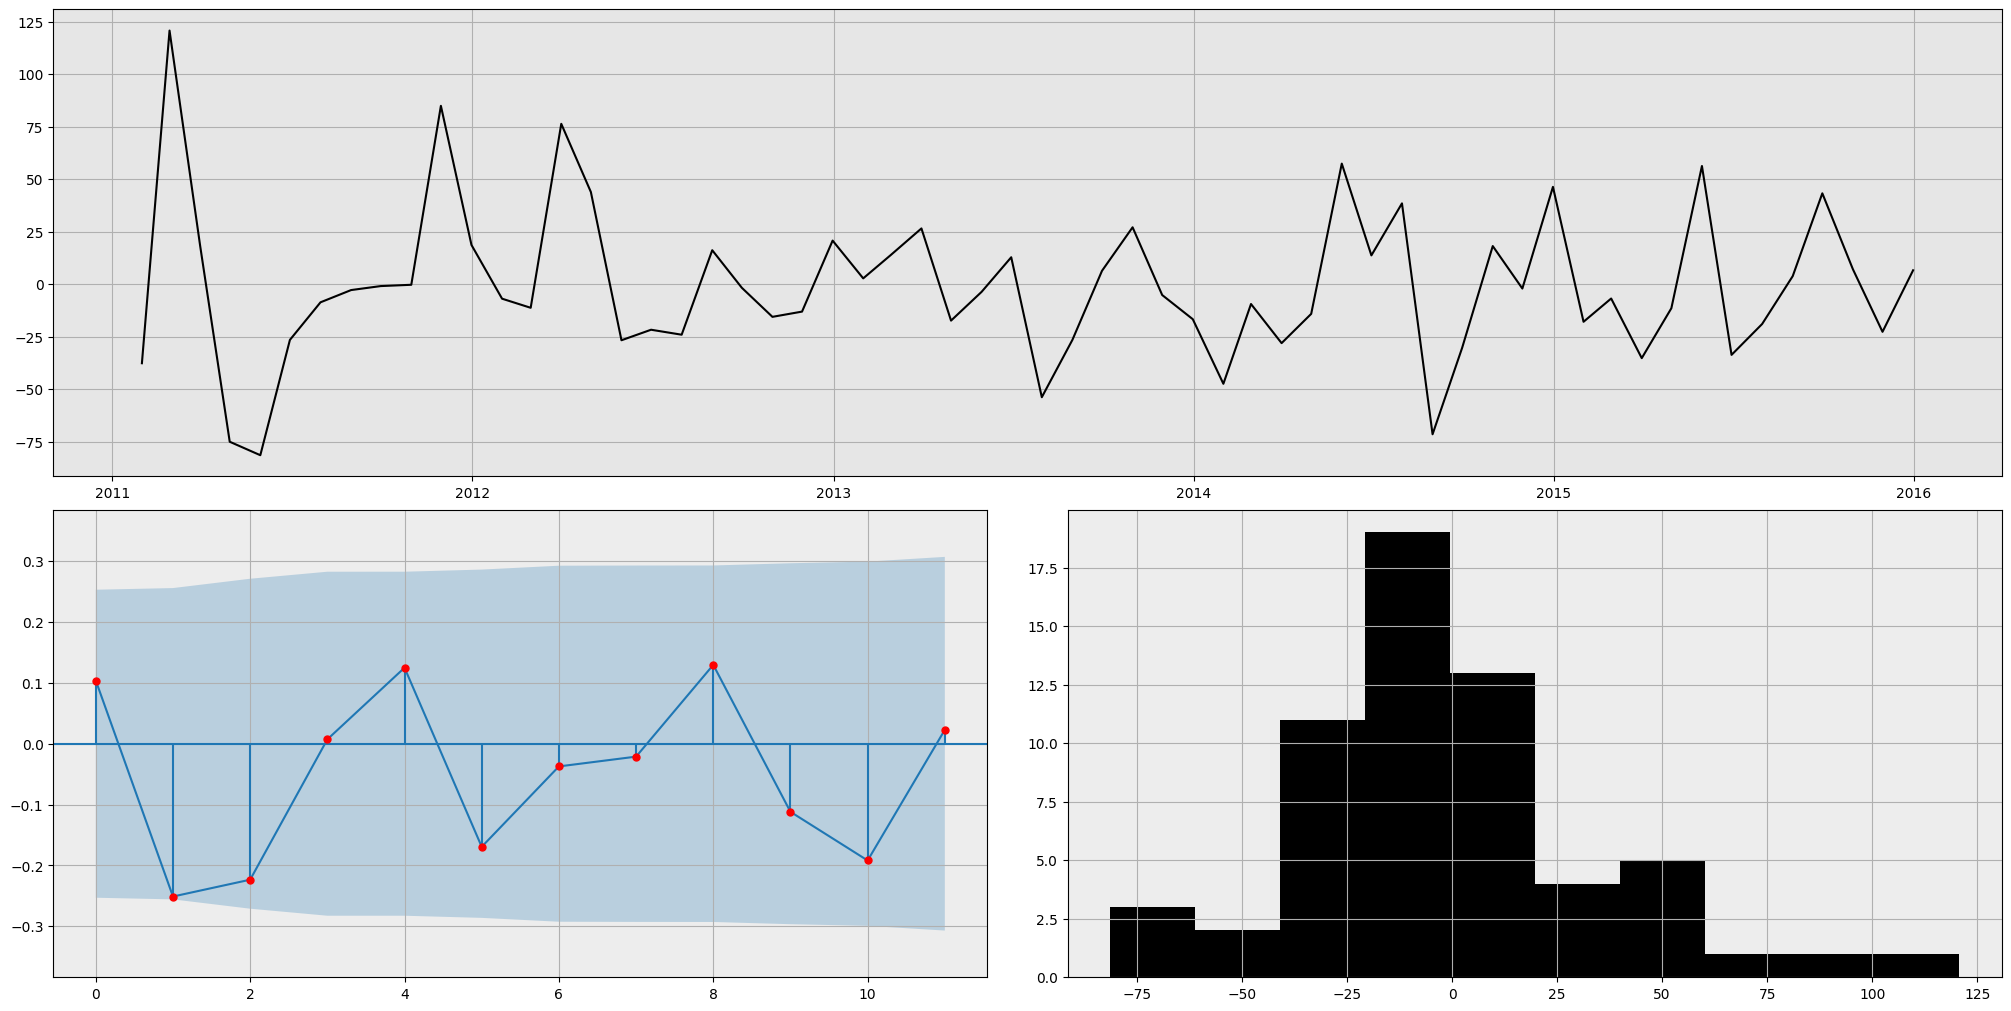

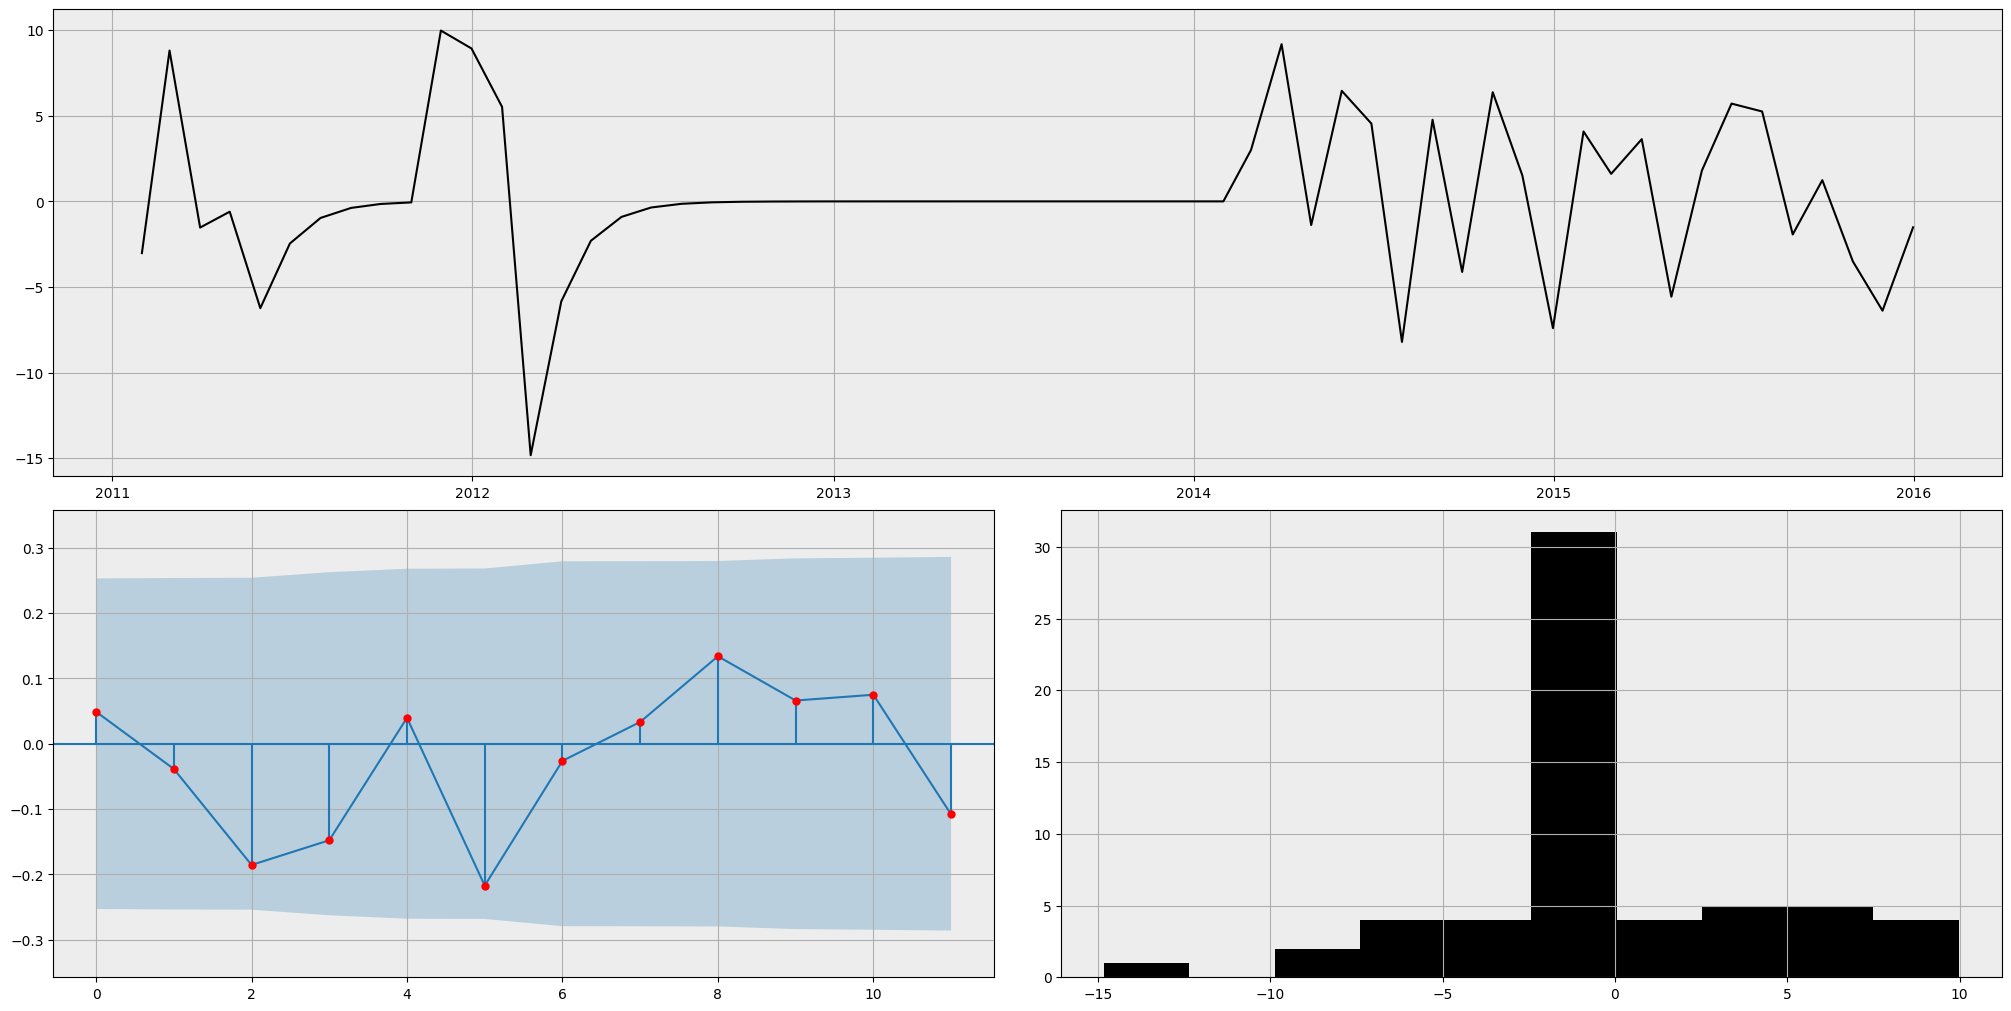

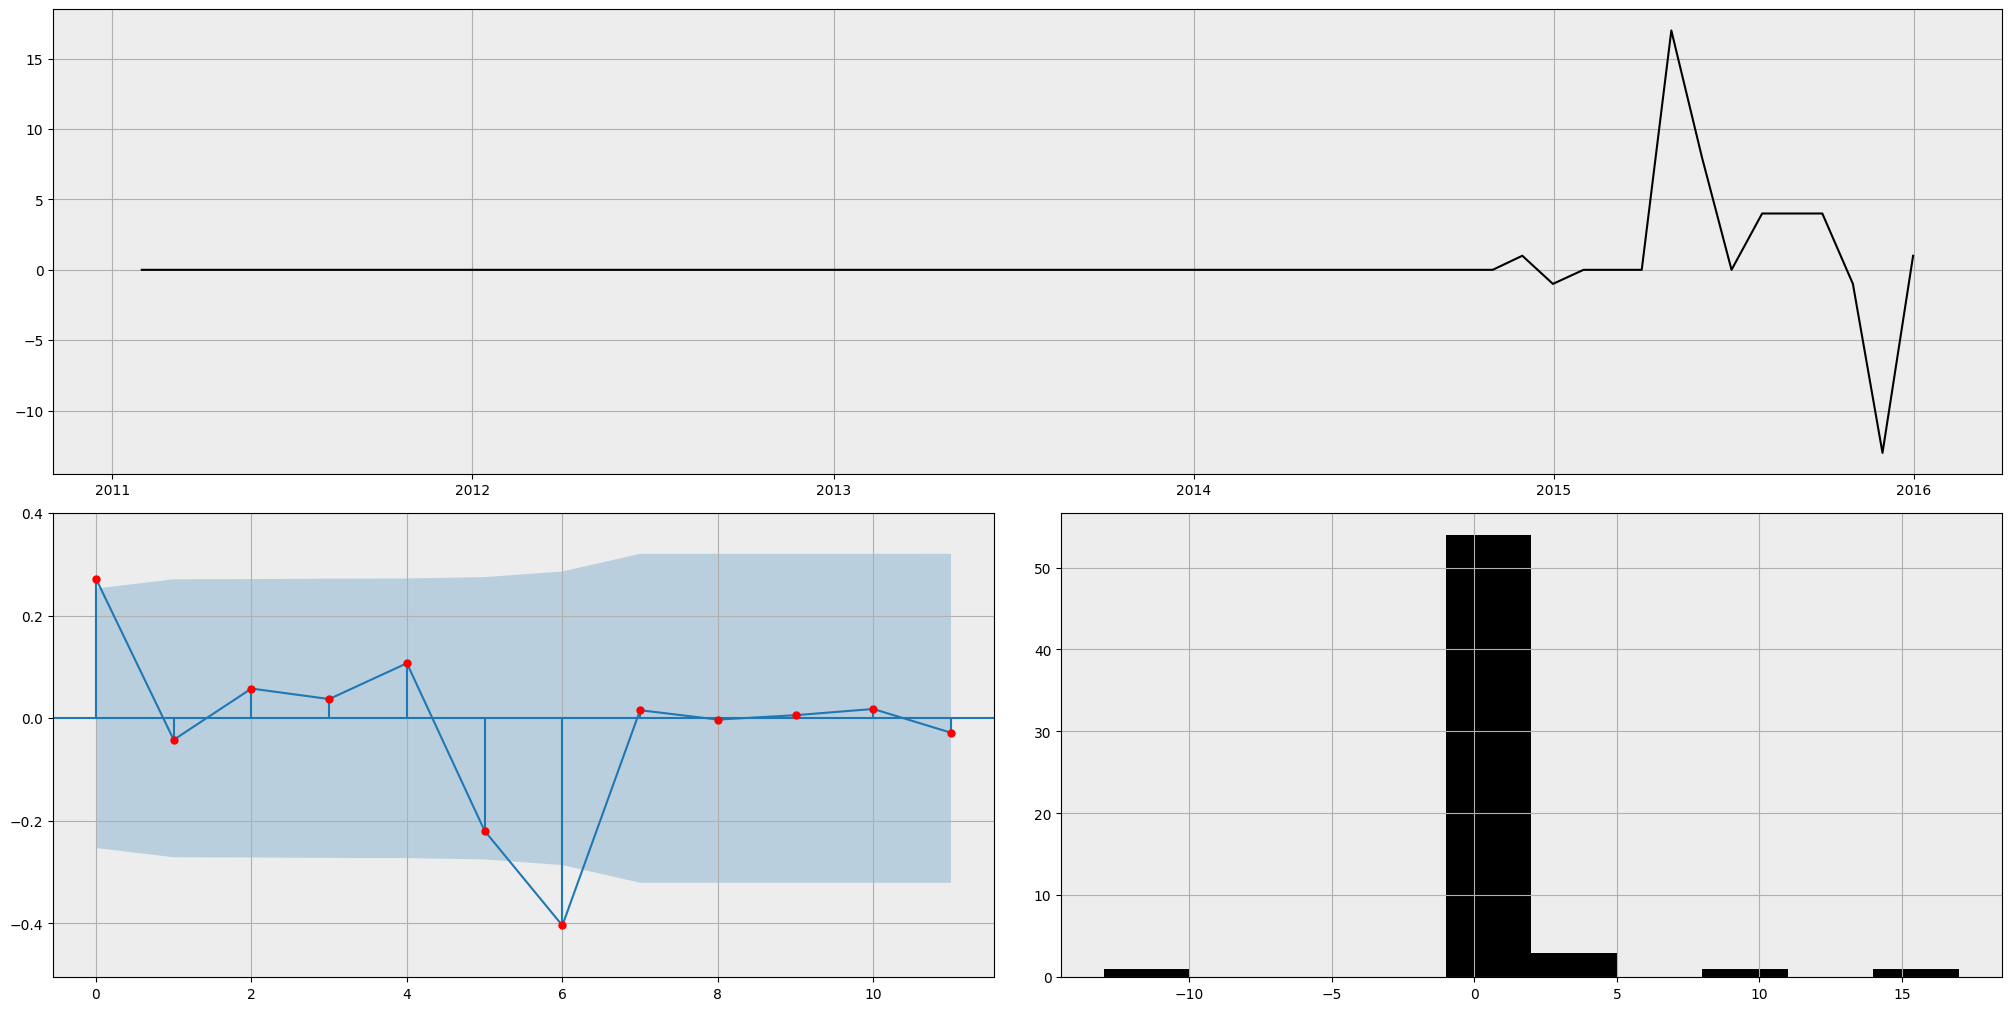

In [25]:
forecaster.residual_diagnosis(model = 'ETS', type = 'random', n = 3)

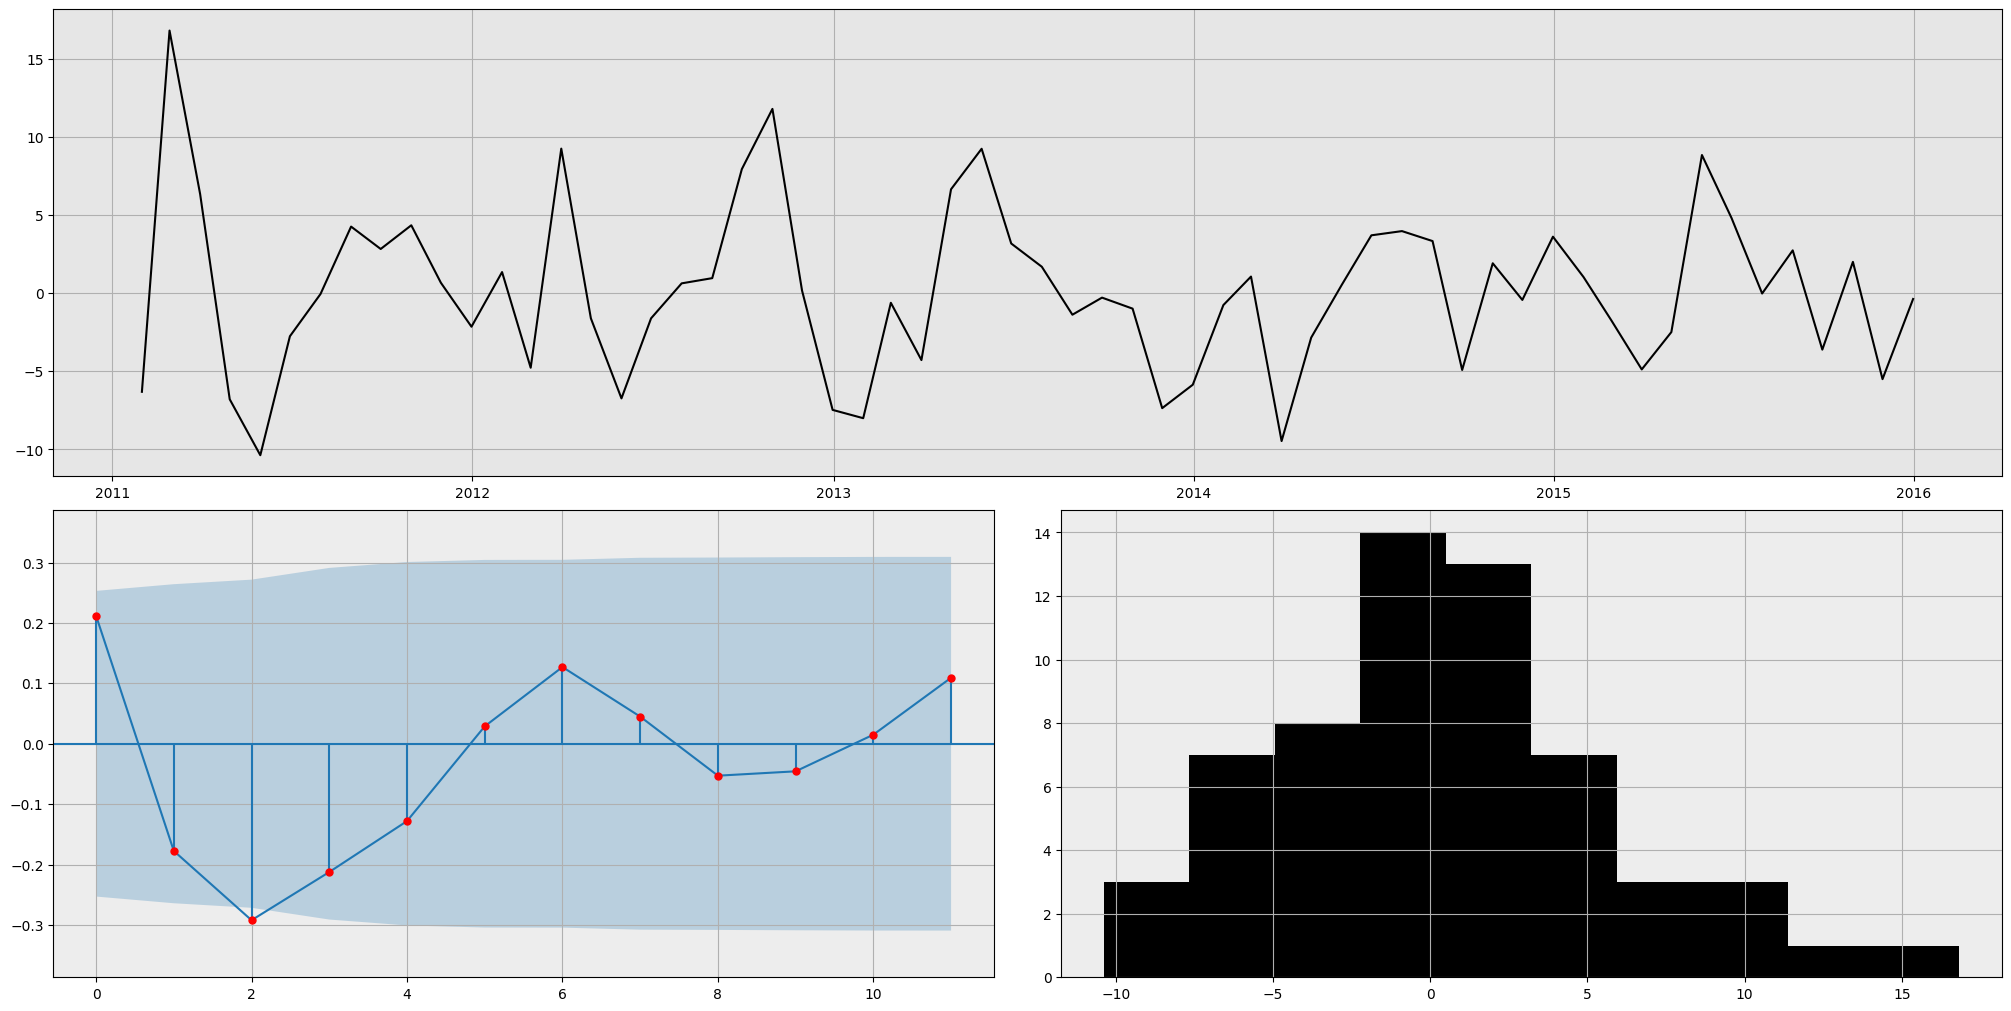

In [26]:
forecaster.residual_diagnosis(model = 'ETS', type = 'aggregate', agg_func = 'mean')

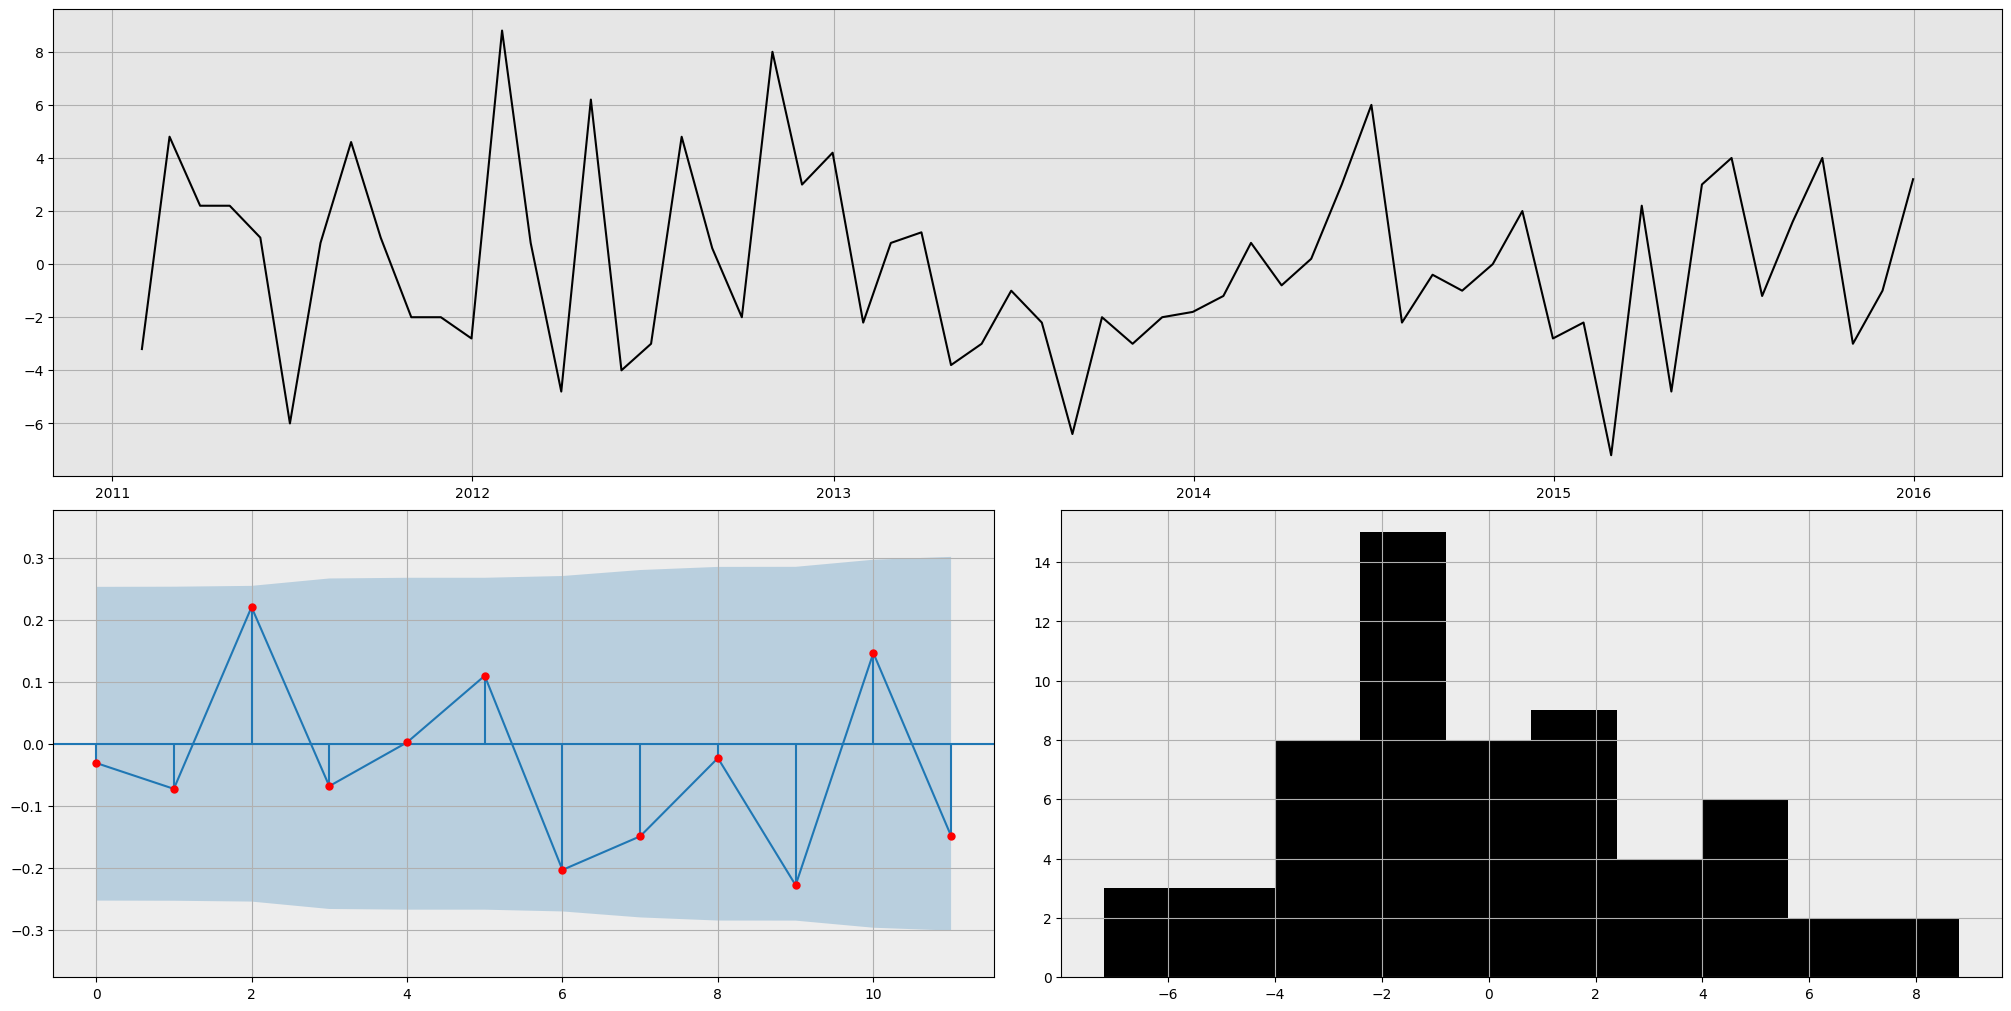

In [28]:
forecaster.residual_diagnosis(model = 'ETS', type = 'invidivual', index_ids = ['HOUSEHOLD_2_090_TX_3'])

In [13]:
index_ids=['HOUSEHOLD_1_428_WI_2', 'FOODS_2_095_TX_3']
residuals[residuals['unique_id'].isin(index_ids)]

,unique_id,Period,residual,Model


In [14]:
forecaster.residual_diagnosis(model = 'ETS', type = 'invidivual', index_ids=['FOODS_1_080_WI_2', 'HOUSEHOLD_2_497_CA_1'])

IndexError: index 0 is out of bounds for axis 0 with size 0

<Figure size 2000x1000 with 0 Axes>